In [ ]:
print("hi")

hi


In [ ]:
!pip install opencv-python ultralytics pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00


Vehicles: 283 | Latest: Car: 100%|#########9| 76000/76350 [21:08<00:05, 58.87frames/s]


⚡ Performance Statistics:
   Average processing time: 15.8 ms/frame
   Average FPS: 63.3
   GPU Used: Yes

✅ Processing Complete!
   Total vehicles counted: 283
   - Cars: 264
   - Buses: 0
   - Trucks: 19
   Data saved to: vehicle_counts.csv
   Output video saved to: output.mp4

📸 Sample frame from processing:


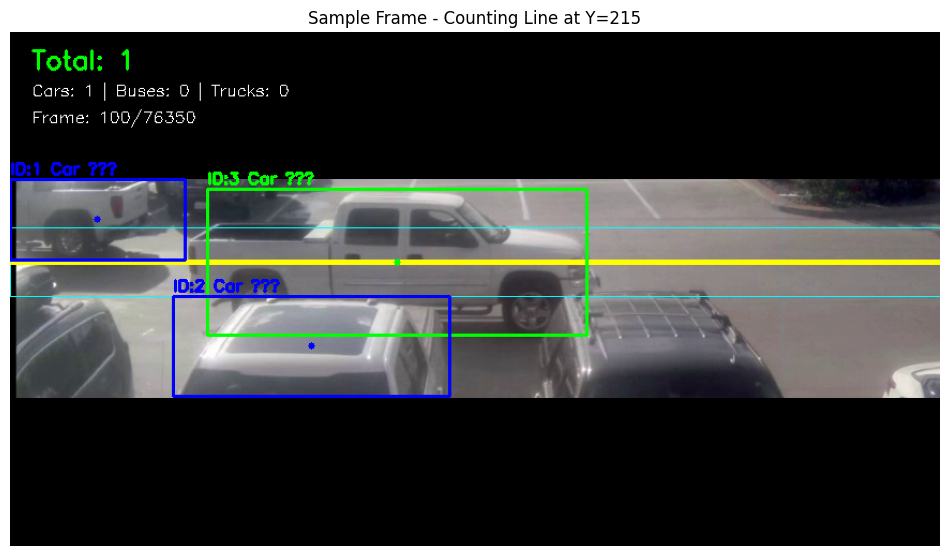


📊 Vehicle Count Over Time:


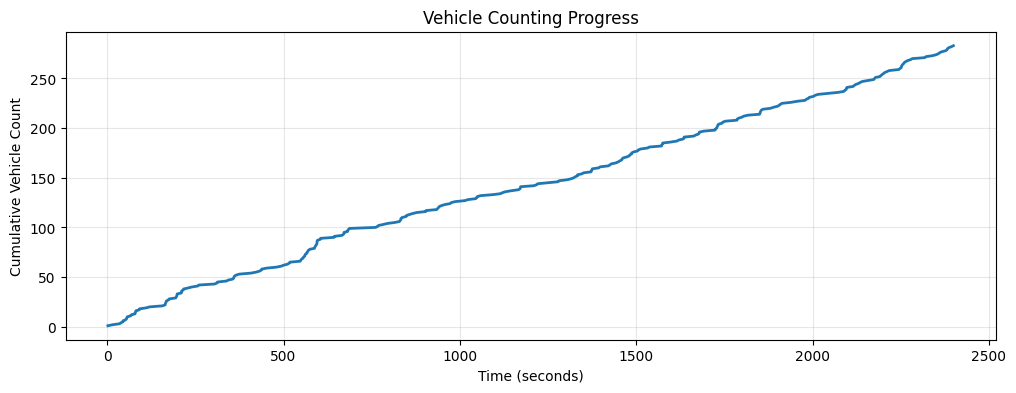


📋 Sample Data (first 5 entries):


,timestamp_sec,cumulative_count,vehicle_type,track_id
0,2.233333,1,Car,3
1,15.800000,2,Car,14
2,35.233333,3,Car,22
3,39.233333,4,Car,26
4,45.033333,5,Car,37



📋 Sample Data (last 5 entries):


,timestamp_sec,cumulative_count,vehicle_type,track_id
278,2381.200000,279,Truck,1328
279,2382.233333,280,Truck,1330
280,2385.966667,281,Car,1338
281,2393.200000,282,Car,1341
282,2399.033333,283,Car,1353


In [ ]:
# ============================================
# GOOGLE COLAB SETUP CELLS
# ============================================

# CELL 1: Install required packages
!pip install ultralytics -q
!pip install pandas opencv-python-headless -q

# CELL 2: Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ No GPU detected. Using CPU (will be slower)")

# CELL 3: Mount Google Drive (optional - for video files)
# Your video path would be like: '/content/drive/MyDrive/your_video.mp4'

# ============================================
# MAIN PROCESSING CODE
# ============================================

import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from IPython.display import HTML, display, clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# --- CONFIGURATION ---
VIDEO_FILE = "test2.mp4"  # Update this path
# For Google Drive: "/content/drive/MyDrive/folder/your_video.mp4"
# For uploaded file: "/content/your_video.mp4"

OUTPUT_CSV = "vehicle_counts.csv"
OUTPUT_VIDEO = "output.mp4"  # Optional: save processed video
COUNTING_LINE_Y = 215  # Adjust based on your video
LINE_THICKNESS = 3
OFFSET = 32  # Detection zone size
CONFIDENCE_THRESHOLD = 0.5  # Lower = more detections
SAVE_OUTPUT_VIDEO = True  # Set True to save processed video
PROCESS_EVERY_N_FRAMES = 1  # Set to 2 or 3 for faster processing

# Visual settings
COUNTED_COLOR = (0, 255, 0)  # Green
TRACKING_COLOR = (255, 0, 0)  # Blue
LINE_COLOR = (0, 255, 255)  # Yellow

def process_video_colab():
    """
    Optimized video processing for Google Colab with GPU acceleration.
    """
    print("🚀 Initializing YOLOv8 model...")

    # Load model and explicitly move to GPU
    model = YOLO('yolov8n.pt')
    if torch.cuda.is_available():
        model.to('cuda')
        print("✅ Model loaded on GPU")
    else:
        print("⚠️ Running on CPU (slower)")

    # Check video file
    if not Path(VIDEO_FILE).exists():
        print(f"❌ Error: Video file '{VIDEO_FILE}' not found!")
        print("Tips:")
        print("  - Upload video using the files panel on the left")
        print("  - Or mount Google Drive and use drive path")
        return

    # Open video
    cap = cv2.VideoCapture(VIDEO_FILE)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video file")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"\n📹 Video Information:")
    print(f"   Resolution: {frame_width}x{frame_height}")
    print(f"   FPS: {fps:.2f}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.1f} seconds")
    print(f"   Counting line: Y={COUNTING_LINE_Y}")

    # Validate counting line position
    if COUNTING_LINE_Y > frame_height or COUNTING_LINE_Y < 0:
        print(f"⚠️ Warning: Counting line Y={COUNTING_LINE_Y} might be outside frame height={frame_height}")

    # Setup video writer if saving output
    out = None
    if SAVE_OUTPUT_VIDEO:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
        print(f"💾 Will save output video to: {OUTPUT_VIDEO}")

    # Initialize tracking variables
    tracked_ids = set()
    counting_data = []
    vehicle_count = 0
    frame_count = 0
    vehicle_positions = {}
    processing_times = []

    # Class names
    class_names = {2: "Car", 5: "Bus", 7: "Truck"}
    vehicle_type_counts = {"Car": 0, "Bus": 0, "Truck": 0}

    print(f"\n🎬 Processing video...")
    print(f"   Processing every {PROCESS_EVERY_N_FRAMES} frame(s)")

    # Create progress bar
    pbar = tqdm(total=total_frames, desc="Processing frames", unit="frames")

    # Store sample frame for visualization
    sample_frame = None

    try:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            frame_count += 1
            pbar.update(1)

            # Skip frames for faster processing
            if frame_count % PROCESS_EVERY_N_FRAMES != 0:
                continue

            # Measure processing time
            start_time = time.time()

            # Get timestamp
            timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

            # Run YOLO detection and tracking with GPU
            with torch.cuda.amp.autocast():  # Mixed precision for faster GPU processing
                results = model.track(
                    frame,
                    persist=True,
                    classes=[2, 5, 7],  # car, bus, truck
                    conf=CONFIDENCE_THRESHOLD,
                    iou=0.5,
                    tracker="bytetrack.yaml",
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=False  # Suppress output for cleaner display
                )

            # Draw counting zone
            cv2.rectangle(frame,
                         (0, COUNTING_LINE_Y - OFFSET),
                         (frame_width, COUNTING_LINE_Y + OFFSET),
                         (255, 255, 0), 1)

            # Draw counting line
            cv2.line(frame, (0, COUNTING_LINE_Y), (frame_width, COUNTING_LINE_Y),
                    LINE_COLOR, LINE_THICKNESS)

            # Process detections
            if results[0].boxes is not None and results[0].boxes.id is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
                track_ids = results[0].boxes.id.cpu().numpy().astype(int)
                confidences = results[0].boxes.conf.cpu().numpy()
                classes = results[0].boxes.cls.cpu().numpy().astype(int)

                for box, track_id, conf, cls in zip(boxes, track_ids, confidences, classes):
                    x1, y1, x2, y2 = box
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2

                    # Track direction
                    if track_id in vehicle_positions:
                        prev_y = vehicle_positions[track_id]
                        direction = "↓" if center_y > prev_y else "↑"
                    else:
                        direction = ""
                    vehicle_positions[track_id] = center_y

                    # Check crossing
                    is_crossing = (COUNTING_LINE_Y - OFFSET) < center_y < (COUNTING_LINE_Y + OFFSET)
                    is_new = track_id not in tracked_ids

                    if is_crossing and is_new:
                        # Count vehicle
                        vehicle_count += 1
                        tracked_ids.add(track_id)
                        vehicle_type = class_names.get(cls, "Vehicle")
                        vehicle_type_counts[vehicle_type] = vehicle_type_counts.get(vehicle_type, 0) + 1
                        counting_data.append([timestamp, vehicle_count, vehicle_type, track_id])
                        color = COUNTED_COLOR

                        # Update progress bar description
                        pbar.set_description(f"Vehicles: {vehicle_count} | Latest: {vehicle_type}")
                    elif track_id in tracked_ids:
                        color = COUNTED_COLOR
                    else:
                        color = TRACKING_COLOR

                    # Draw bounding box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    label = f"ID:{track_id} {class_names.get(cls, 'V')} {direction}"
                    cv2.putText(frame, label, (x1, y1 - 5),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    cv2.circle(frame, (center_x, center_y), 3, color, -1)

            # Add statistics overlay
            cv2.rectangle(frame, (10, 10), (300, 100), (0, 0, 0), -1)
            cv2.putText(frame, f"Total: {vehicle_count}", (20, 35),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.putText(frame, f"Cars: {vehicle_type_counts.get('Car', 0)} | "
                              f"Buses: {vehicle_type_counts.get('Bus', 0)} | "
                              f"Trucks: {vehicle_type_counts.get('Truck', 0)}",
                       (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.putText(frame, f"Frame: {frame_count}/{total_frames}", (20, 85),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # Save sample frame for display
            if frame_count == min(100, total_frames // 2):
                sample_frame = frame.copy()

            # Write frame to output video
            if out is not None:
                out.write(frame)

            # Track processing time
            processing_time = time.time() - start_time
            processing_times.append(processing_time)

            # Clear output periodically in Colab to prevent memory issues
            if frame_count % 500 == 0:
                clear_output(wait=True)
                display(pbar.container)

    except KeyboardInterrupt:
        print("\n⚠️ Processing interrupted by user")

    finally:
        # Cleanup
        pbar.close()
        cap.release()
        if out is not None:
            out.release()
        cv2.destroyAllWindows()

    # Calculate statistics
    if processing_times:
        avg_time = np.mean(processing_times)
        avg_fps = 1.0 / avg_time if avg_time > 0 else 0
        print(f"\n⚡ Performance Statistics:")
        print(f"   Average processing time: {avg_time*1000:.1f} ms/frame")
        print(f"   Average FPS: {avg_fps:.1f}")
        print(f"   GPU Used: {'Yes' if torch.cuda.is_available() else 'No'}")

    # Save results to CSV
    if counting_data:
        df = pd.DataFrame(counting_data, columns=["timestamp_sec", "cumulative_count", "vehicle_type", "track_id"])
        df.to_csv(OUTPUT_CSV, index=False)

        print(f"\n✅ Processing Complete!")
        print(f"   Total vehicles counted: {vehicle_count}")
        print(f"   - Cars: {vehicle_type_counts.get('Car', 0)}")
        print(f"   - Buses: {vehicle_type_counts.get('Bus', 0)}")
        print(f"   - Trucks: {vehicle_type_counts.get('Truck', 0)}")
        print(f"   Data saved to: {OUTPUT_CSV}")
        if SAVE_OUTPUT_VIDEO:
            print(f"   Output video saved to: {OUTPUT_VIDEO}")

        # Display sample frame
        if sample_frame is not None:
            print(f"\n📸 Sample frame from processing:")
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Sample Frame - Counting Line at Y={COUNTING_LINE_Y}")
            plt.axis('off')
            plt.show()

        # Plot counting over time
        print(f"\n📊 Vehicle Count Over Time:")
        plt.figure(figsize=(12, 4))
        plt.plot(df['timestamp_sec'], df['cumulative_count'], linewidth=2)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Cumulative Vehicle Count')
        plt.title('Vehicle Counting Progress')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Show first few and last few entries
        print(f"\n📋 Sample Data (first 5 entries):")
        display(df.head())
        if len(df) > 5:
            print(f"\n📋 Sample Data (last 5 entries):")
            display(df.tail())
    else:
        print(f"\n⚠️ No vehicles were counted.")
        print(f"   Check if counting line Y={COUNTING_LINE_Y} is positioned correctly")

# ============================================
# RUN THE PROCESSING
# ============================================

if __name__ == "__main__":
    process_video_colab()

# ============================================
# OPTIONAL: Quick visualization of results
# ============================================

def visualize_results(csv_file="vehicle_counts.csv"):
    """
    Quick visualization of the counting results
    """
    if not Path(csv_file).exists():
        print(f"CSV file {csv_file} not found. Run processing first.")
        return

    df = pd.read_csv(csv_file)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Cumulative count
    axes[0].plot(df['timestamp_sec'], df['cumulative_count'], linewidth=2, color='blue')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Cumulative Count')
    axes[0].set_title('Vehicle Count Over Time')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Vehicle type distribution
    vehicle_counts = df['vehicle_type'].value_counts()
    axes[1].bar(vehicle_counts.index, vehicle_counts.values, color=['blue', 'green', 'red'])
    axes[1].set_xlabel('Vehicle Type')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Vehicle Type Distribution')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Summary Statistics:")
    print(f"   Total vehicles: {len(df)}")
    print(f"   Duration: {df['timestamp_sec'].max():.1f} seconds")
    print(f"   Average rate: {len(df)/df['timestamp_sec'].max():.2f} vehicles/second")

# Uncomment to run visualization after processing:
# visualize_results()

Vehicle Count Animation Creator
✅ Loaded 283 data points from vehicle_counts.csv
🎬 Creating animation... This may take a moment.
   Total frames: 283
✅ Animation saved successfully as car_count_animation.gif
   File size will be approximately 2.8 MB


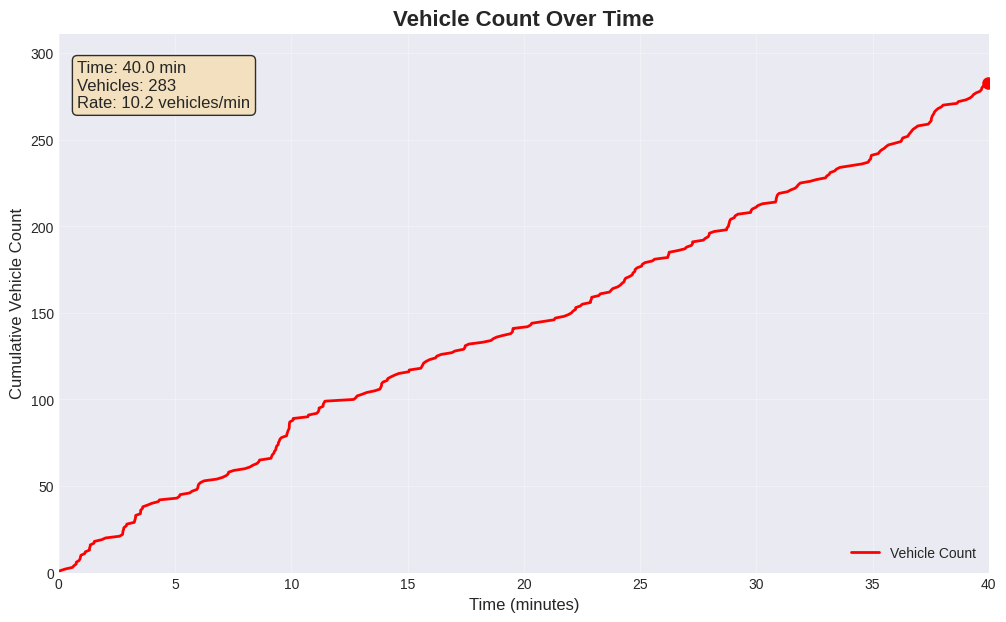


📊 Creating static plot...
📊 Static plot saved as 'traffic_analysis.png'


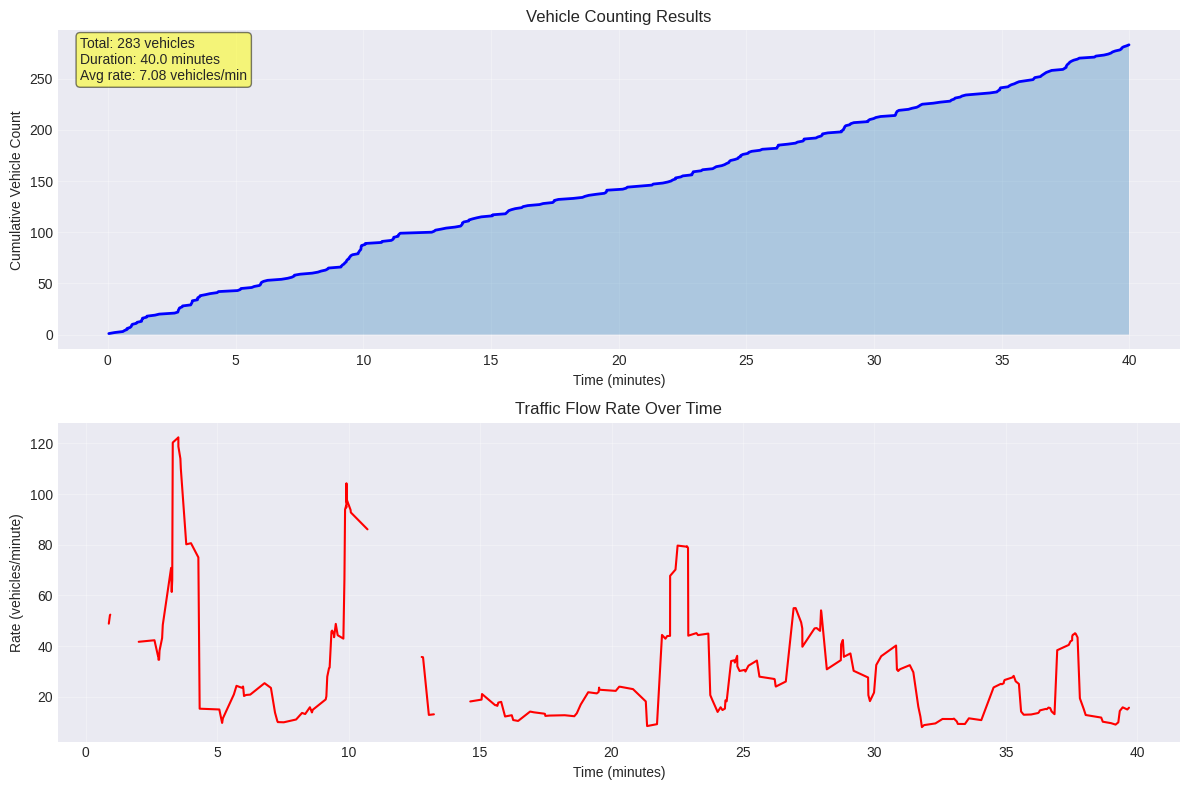

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# --- CONFIGURATION ---
INPUT_CSV = "vehicle_counts.csv"  # or "vehicle_counts.csv" depending on your file
OUTPUT_GIF = "car_count_animation.gif"
VIDEO_DURATION_MIN = 40  # Duration of the original video in minutes

def create_animation():
    """
    Reads the count data and generates an animated GIF of the graph.
    X-axis is in minutes.
    """
    # Load data
    try:
        data = pd.read_csv(INPUT_CSV)
        print(f"✅ Loaded {len(data)} data points from {INPUT_CSV}")
    except FileNotFoundError:
        print(f"❌ Error: The file {INPUT_CSV} was not found.")
        print("Please run the video processing script first.")
        return

    if data.empty:
        print("❌ The data file is empty. No animation will be created.")
        return

    # Check column names and adapt
    if 'cumulative_count' in data.columns:
        count_col = 'cumulative_count'
    elif 'car_count' in data.columns:
        count_col = 'car_count'
    else:
        print(f"❌ Error: Could not find count column in CSV")
        print(f"   Available columns: {data.columns.tolist()}")
        return

    if 'timestamp_sec' not in data.columns:
        print(f"❌ Error: 'timestamp_sec' column not found")
        print(f"   Available columns: {data.columns.tolist()}")
        return

    # Convert timestamps to minutes for plotting
    data = data.copy()
    data['time_min'] = data['timestamp_sec'] / 60.0

    # Set up the plot with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Set axis limits (in minutes)
    max_time_min = max(data['time_min'].max(), VIDEO_DURATION_MIN)
    ax.set_xlim(0, max_time_min)
    ax.set_ylim(0, data[count_col].max() * 1.1)  # Y-axis with 10% padding

    # Labels and title
    ax.set_title('Vehicle Count Over Time', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (minutes)', fontsize=12)
    ax.set_ylabel('Cumulative Vehicle Count', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Create line objects
    line, = ax.plot([], [], 'r-', linewidth=2, label='Vehicle Count')
    point, = ax.plot([], [], 'ro', markersize=8)  # Current point indicator

    # Add text displays
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                        fontsize=12, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Add legend
    ax.legend(loc='lower right')

    def init():
        """Initialize animation elements."""
        line.set_data([], [])
        point.set_data([], [])
        time_text.set_text('')
        return line, point, time_text

    def update(frame):
        """Update the plot for each frame of the animation."""
        # Get data up to the current frame
        x = data['time_min'][:frame+1]
        y = data[count_col][:frame+1]

        # Update the line plot
        line.set_data(x, y)

        # Update the current point indicator
        if frame < len(data):
            point.set_data([data['time_min'].iloc[frame]],
                           [data[count_col].iloc[frame]])

        # Update the text display
        if frame < len(data):
            current_time_sec = data['timestamp_sec'].iloc[frame]
            current_time_min = data['time_min'].iloc[frame]
            current_count = data[count_col].iloc[frame]

            # Calculate rate if we have enough data (vehicles per minute)
            if frame > 10:
                recent_time_sec = data['timestamp_sec'].iloc[frame-10]
                recent_count = data[count_col].iloc[frame-10]
                dt_sec = current_time_sec - recent_time_sec
                rate_vpm = ((current_count - recent_count) / dt_sec * 60.0) if dt_sec > 0 else 0.0
                rate_text = f'\nRate: {rate_vpm:.1f} vehicles/min'
            else:
                rate_text = ''

            time_text.set_text(
                f'Time: {current_time_min:.1f} min\n'
                f'Vehicles: {current_count}{rate_text}'
            )

        return line, point, time_text

    # Create the animation
    print("🎬 Creating animation... This may take a moment.")
    print(f"   Total frames: {len(data)}")

    # Calculate interval for smooth playback
    # Aim for animation to last about 10-20 seconds
    target_duration_seconds = min(20, max(10, len(data) / 50))
    interval = (target_duration_seconds * 1000) / len(data)  # milliseconds per frame

    ani = FuncAnimation(fig, update, frames=len(data),
                        init_func=init, blit=True, interval=interval, repeat=True)

    # Save the animation
    try:
        # Try to save as GIF
        ani.save(OUTPUT_GIF, writer='pillow', fps=25)
        print(f"✅ Animation saved successfully as {OUTPUT_GIF}")
        print(f"   File size will be approximately {len(data) * 0.01:.1f} MB")
    except Exception as e:
        print(f"⚠️ Could not save as GIF: {e}")
        try:
            # Fallback to MP4 if available
            output_mp4 = OUTPUT_GIF.replace('.gif', '.mp4')
            ani.save(output_mp4, writer='ffmpeg', fps=25)
            print(f"✅ Animation saved as {output_mp4} instead")
        except Exception as e2:
            print(f"❌ Could not save animation: {e2}")
            print("Displaying plot instead.")

    plt.show()  # Display the final plot

def create_static_plot():
    """
    Creates a static version of the plot for quick viewing
    X-axis is in minutes.
    """
    try:
        data = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print(f"❌ Error: {INPUT_CSV} not found")
        return

    if 'cumulative_count' in data.columns:
        count_col = 'cumulative_count'
    elif 'car_count' in data.columns:
        count_col = 'car_count'
    else:
        print(f"❌ Error: Could not find count column in CSV")
        print(f"   Available columns: {data.columns.tolist()}")
        return

    if 'timestamp_sec' not in data.columns:
        print(f"❌ Error: 'timestamp_sec' column not found")
        print(f"   Available columns: {data.columns.tolist()}")
        return

    data = data.copy()
    data['time_min'] = data['timestamp_sec'] / 60.0

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot 1: Cumulative count
    ax1.plot(data['time_min'], data[count_col], 'b-', linewidth=2)
    ax1.fill_between(data['time_min'], 0, data[count_col], alpha=0.3)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Cumulative Vehicle Count')
    ax1.set_title('Vehicle Counting Results')
    ax1.grid(True, alpha=0.3)

    # Add annotations for key statistics
    total_vehicles = data[count_col].iloc[-1]
    total_time_sec = data['timestamp_sec'].iloc[-1]
    total_time_min = total_time_sec / 60.0
    avg_rate_vpm = (total_vehicles / total_time_sec * 60.0) if total_time_sec > 0 else 0

    ax1.text(0.02, 0.98, f'Total: {total_vehicles} vehicles\n'
                         f'Duration: {total_time_min:.1f} minutes\n'
                         f'Avg rate: {avg_rate_vpm:.2f} vehicles/min',
             transform=ax1.transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    # Plot 2: Rate over time (vehicles per minute)
    if len(data) > 1:
        # Calculate rate using rolling window (vehicles/min)
        window_size = min(10, max(2, len(data) // 4))
        if window_size > 1:
            # diff() per sample -> divide by diff in seconds, then *60 for per minute
            delta_count = data[count_col].diff()
            delta_time_sec = data['timestamp_sec'].diff()
            inst_rate_vpm = (delta_count / delta_time_sec) * 60.0
            data['rate_vpm'] = inst_rate_vpm.rolling(window=window_size, center=True).mean()

            ax2.plot(data['time_min'], data['rate_vpm'], 'r-', linewidth=1.5)
            ax2.set_xlabel('Time (minutes)')
            ax2.set_ylabel('Rate (vehicles/minute)')
            ax2.set_title('Traffic Flow Rate Over Time')
            ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('traffic_analysis.png', dpi=100, bbox_inches='tight')
    print("📊 Static plot saved as 'traffic_analysis.png'")
    plt.show()

if __name__ == "__main__":
    print("=" * 50)
    print("Vehicle Count Animation Creator")
    print("=" * 50)

    # Create animated version
    create_animation()

    # Also create static version for quick reference
    print("\n📊 Creating static plot...")
    create_static_plot()
